# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [9]:
!ls

C1_W1_Lab_1_functional-practice.ipynb ENB2012_data.xlsx
C1_W1_Lab_2_multi-output.ipynb


In [11]:
# Specify data URI
URI = './ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI, engine='openpyxl')
df = df.sample(frac=1).reset_index(drop=True)

del df['Unnamed: 10']
del df['Unnamed: 11']

print(df.head(10))
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

     X1     X2     X3     X4   X5  X6    X7  X8     Y1     Y2
0  0.90  563.5  318.5  122.5  7.0   3  0.40   5  35.01  33.14
1  0.74  686.0  245.0  220.5  3.5   2  0.10   4  10.08  13.20
2  0.82  612.5  318.5  147.0  7.0   5  0.10   3  23.87  24.93
3  0.76  661.5  416.5  122.5  7.0   5  0.25   4  36.26  37.51
4  0.69  735.0  294.0  220.5  3.5   4  0.10   5  11.11  14.46
5  0.66  759.5  318.5  220.5  3.5   4  0.10   2  11.33  15.00
6  0.71  710.5  269.5  220.5  3.5   2  0.00   0   6.37  11.27
7  0.64  784.0  343.0  220.5  3.5   4  0.40   5  18.16  20.71
8  0.74  686.0  245.0  220.5  3.5   2  0.00   0   6.07  10.90
9  0.86  588.0  294.0  147.0  7.0   5  0.40   2  31.64  36.86


## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [12]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [13]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Train the Model

In [14]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 3ms/step - loss: 579.3973 - y1_output_loss: 279.8378 - y2_output_loss: 299.5594 - y1_output_root_mean_squared_error: 16.1196 - y2_output_root_mean_squared_error: 16.6162 - val_loss: 53.3107 - val_y1_output_loss: 15.7976 - val_y2_output_loss: 37.5131 - val_y1_output_root_mean_squared_error: 3.9746 - val_y2_output_root_mean_squared_error: 6.1248
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 40.2081 - y1_output_loss: 12.6934 - y2_output_loss: 27.5147 - y1_output_root_mean_squared_error: 3.5511 - y2_output_root_mean_squared_error: 5.1700 - val_loss: 31.0668 - val_y1_output_loss: 12.1592 - val_y2_output_loss: 18.9075 - val_y1_output_root_mean_squared_error: 3.4870 - val_y2_output_root_mean_squared_error: 4.3483
Epoch 3/500
62/62 [==============================] - 0s 1ms/step - loss: 31.4808 - y1_output_loss: 11.0845 - y2_output_loss: 20.3963 - y1_output_root_mean_squared_error: 3.3211 - y2_output_root_mean_sq

Epoch 22/500
62/62 [==============================] - 0s 2ms/step - loss: 15.2647 - y1_output_loss: 5.4437 - y2_output_loss: 9.8210 - y1_output_root_mean_squared_error: 2.3247 - y2_output_root_mean_squared_error: 3.1176 - val_loss: 11.6411 - val_y1_output_loss: 5.1401 - val_y2_output_loss: 6.5010 - val_y1_output_root_mean_squared_error: 2.2672 - val_y2_output_root_mean_squared_error: 2.5497
Epoch 23/500
62/62 [==============================] - 0s 1ms/step - loss: 14.6539 - y1_output_loss: 5.3297 - y2_output_loss: 9.3243 - y1_output_root_mean_squared_error: 2.3063 - y2_output_root_mean_squared_error: 3.0500 - val_loss: 20.0855 - val_y1_output_loss: 6.4877 - val_y2_output_loss: 13.5978 - val_y1_output_root_mean_squared_error: 2.5471 - val_y2_output_root_mean_squared_error: 3.6875
Epoch 24/500
62/62 [==============================] - 0s 1ms/step - loss: 13.9597 - y1_output_loss: 5.2855 - y2_output_loss: 8.6742 - y1_output_root_mean_squared_error: 2.2798 - y2_output_root_mean_squared_error

Epoch 43/500
62/62 [==============================] - 0s 1ms/step - loss: 7.8102 - y1_output_loss: 2.0187 - y2_output_loss: 5.7915 - y1_output_root_mean_squared_error: 1.4180 - y2_output_root_mean_squared_error: 2.3786 - val_loss: 8.1612 - val_y1_output_loss: 3.0211 - val_y2_output_loss: 5.1401 - val_y1_output_root_mean_squared_error: 1.7381 - val_y2_output_root_mean_squared_error: 2.2672
Epoch 44/500
62/62 [==============================] - 0s 1ms/step - loss: 9.3905 - y1_output_loss: 2.9171 - y2_output_loss: 6.4733 - y1_output_root_mean_squared_error: 1.7052 - y2_output_root_mean_squared_error: 2.5365 - val_loss: 43.5338 - val_y1_output_loss: 12.5702 - val_y2_output_loss: 30.9636 - val_y1_output_root_mean_squared_error: 3.5454 - val_y2_output_root_mean_squared_error: 5.5645
Epoch 45/500
62/62 [==============================] - 0s 1ms/step - loss: 21.0313 - y1_output_loss: 5.7276 - y2_output_loss: 15.3037 - y1_output_root_mean_squared_error: 2.2932 - y2_output_root_mean_squared_error:

Epoch 64/500
62/62 [==============================] - 0s 1ms/step - loss: 5.6730 - y1_output_loss: 1.9438 - y2_output_loss: 3.7292 - y1_output_root_mean_squared_error: 1.3846 - y2_output_root_mean_squared_error: 1.9234 - val_loss: 4.1064 - val_y1_output_loss: 1.2473 - val_y2_output_loss: 2.8591 - val_y1_output_root_mean_squared_error: 1.1168 - val_y2_output_root_mean_squared_error: 1.6909
Epoch 65/500
62/62 [==============================] - 0s 1ms/step - loss: 3.9371 - y1_output_loss: 1.2698 - y2_output_loss: 2.6673 - y1_output_root_mean_squared_error: 1.1241 - y2_output_root_mean_squared_error: 1.6179 - val_loss: 4.9390 - val_y1_output_loss: 1.6769 - val_y2_output_loss: 3.2621 - val_y1_output_root_mean_squared_error: 1.2950 - val_y2_output_root_mean_squared_error: 1.8061
Epoch 66/500
62/62 [==============================] - 0s 1ms/step - loss: 4.4882 - y1_output_loss: 1.4526 - y2_output_loss: 3.0357 - y1_output_root_mean_squared_error: 1.2033 - y2_output_root_mean_squared_error: 1.72

Epoch 85/500
62/62 [==============================] - 0s 2ms/step - loss: 2.7807 - y1_output_loss: 0.7864 - y2_output_loss: 1.9944 - y1_output_root_mean_squared_error: 0.8842 - y2_output_root_mean_squared_error: 1.4037 - val_loss: 2.8064 - val_y1_output_loss: 0.7198 - val_y2_output_loss: 2.0866 - val_y1_output_root_mean_squared_error: 0.8484 - val_y2_output_root_mean_squared_error: 1.4445
Epoch 86/500
62/62 [==============================] - 0s 2ms/step - loss: 4.2054 - y1_output_loss: 1.0114 - y2_output_loss: 3.1940 - y1_output_root_mean_squared_error: 0.9845 - y2_output_root_mean_squared_error: 1.7508 - val_loss: 5.1355 - val_y1_output_loss: 1.0159 - val_y2_output_loss: 4.1196 - val_y1_output_root_mean_squared_error: 1.0079 - val_y2_output_root_mean_squared_error: 2.0297
Epoch 87/500
62/62 [==============================] - 0s 1ms/step - loss: 3.7656 - y1_output_loss: 0.9711 - y2_output_loss: 2.7945 - y1_output_root_mean_squared_error: 0.9778 - y2_output_root_mean_squared_error: 1.65

Epoch 106/500
62/62 [==============================] - 0s 1ms/step - loss: 2.0815 - y1_output_loss: 0.4147 - y2_output_loss: 1.6667 - y1_output_root_mean_squared_error: 0.6432 - y2_output_root_mean_squared_error: 1.2881 - val_loss: 5.1562 - val_y1_output_loss: 0.6019 - val_y2_output_loss: 4.5543 - val_y1_output_root_mean_squared_error: 0.7758 - val_y2_output_root_mean_squared_error: 2.1341
Epoch 107/500
62/62 [==============================] - 0s 1ms/step - loss: 2.7453 - y1_output_loss: 0.5015 - y2_output_loss: 2.2438 - y1_output_root_mean_squared_error: 0.7062 - y2_output_root_mean_squared_error: 1.4851 - val_loss: 3.5920 - val_y1_output_loss: 0.7048 - val_y2_output_loss: 2.8872 - val_y1_output_root_mean_squared_error: 0.8395 - val_y2_output_root_mean_squared_error: 1.6992
Epoch 108/500
62/62 [==============================] - 0s 1ms/step - loss: 2.4656 - y1_output_loss: 0.5216 - y2_output_loss: 1.9440 - y1_output_root_mean_squared_error: 0.7204 - y2_output_root_mean_squared_error: 1

Epoch 127/500
62/62 [==============================] - 0s 1ms/step - loss: 2.1038 - y1_output_loss: 0.3760 - y2_output_loss: 1.7278 - y1_output_root_mean_squared_error: 0.6059 - y2_output_root_mean_squared_error: 1.3078 - val_loss: 2.8306 - val_y1_output_loss: 0.5842 - val_y2_output_loss: 2.2464 - val_y1_output_root_mean_squared_error: 0.7643 - val_y2_output_root_mean_squared_error: 1.4988
Epoch 128/500
62/62 [==============================] - 0s 1ms/step - loss: 2.3015 - y1_output_loss: 0.5167 - y2_output_loss: 1.7848 - y1_output_root_mean_squared_error: 0.7158 - y2_output_root_mean_squared_error: 1.3302 - val_loss: 2.0339 - val_y1_output_loss: 0.4672 - val_y2_output_loss: 1.5667 - val_y1_output_root_mean_squared_error: 0.6835 - val_y2_output_root_mean_squared_error: 1.2517
Epoch 129/500
62/62 [==============================] - 0s 1ms/step - loss: 1.8595 - y1_output_loss: 0.4053 - y2_output_loss: 1.4542 - y1_output_root_mean_squared_error: 0.6322 - y2_output_root_mean_squared_error: 1

Epoch 148/500
62/62 [==============================] - 0s 2ms/step - loss: 1.5383 - y1_output_loss: 0.4029 - y2_output_loss: 1.1354 - y1_output_root_mean_squared_error: 0.6300 - y2_output_root_mean_squared_error: 1.0627 - val_loss: 3.9348 - val_y1_output_loss: 0.6169 - val_y2_output_loss: 3.3178 - val_y1_output_root_mean_squared_error: 0.7855 - val_y2_output_root_mean_squared_error: 1.8215
Epoch 149/500
62/62 [==============================] - 0s 1ms/step - loss: 8.8125 - y1_output_loss: 2.1226 - y2_output_loss: 6.6898 - y1_output_root_mean_squared_error: 1.4112 - y2_output_root_mean_squared_error: 2.5382 - val_loss: 2.4545 - val_y1_output_loss: 0.5800 - val_y2_output_loss: 1.8744 - val_y1_output_root_mean_squared_error: 0.7616 - val_y2_output_root_mean_squared_error: 1.3691
Epoch 150/500
62/62 [==============================] - 0s 1ms/step - loss: 1.9786 - y1_output_loss: 0.4152 - y2_output_loss: 1.5634 - y1_output_root_mean_squared_error: 0.6399 - y2_output_root_mean_squared_error: 1

Epoch 169/500
62/62 [==============================] - 0s 1ms/step - loss: 3.2900 - y1_output_loss: 0.8818 - y2_output_loss: 2.4082 - y1_output_root_mean_squared_error: 0.9334 - y2_output_root_mean_squared_error: 1.5381 - val_loss: 7.0376 - val_y1_output_loss: 0.9566 - val_y2_output_loss: 6.0810 - val_y1_output_root_mean_squared_error: 0.9780 - val_y2_output_root_mean_squared_error: 2.4660
Epoch 170/500
62/62 [==============================] - 0s 1ms/step - loss: 5.5547 - y1_output_loss: 1.2419 - y2_output_loss: 4.3128 - y1_output_root_mean_squared_error: 1.0822 - y2_output_root_mean_squared_error: 2.0119 - val_loss: 1.6389 - val_y1_output_loss: 0.3694 - val_y2_output_loss: 1.2694 - val_y1_output_root_mean_squared_error: 0.6078 - val_y2_output_root_mean_squared_error: 1.1267
Epoch 171/500
62/62 [==============================] - 0s 1ms/step - loss: 2.1021 - y1_output_loss: 0.3820 - y2_output_loss: 1.7201 - y1_output_root_mean_squared_error: 0.6100 - y2_output_root_mean_squared_error: 1

Epoch 190/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4042 - y1_output_loss: 0.2986 - y2_output_loss: 1.1056 - y1_output_root_mean_squared_error: 0.5448 - y2_output_root_mean_squared_error: 1.0457 - val_loss: 1.5088 - val_y1_output_loss: 0.3295 - val_y2_output_loss: 1.1793 - val_y1_output_root_mean_squared_error: 0.5740 - val_y2_output_root_mean_squared_error: 1.0859
Epoch 191/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2247 - y1_output_loss: 0.2403 - y2_output_loss: 0.9844 - y1_output_root_mean_squared_error: 0.4900 - y2_output_root_mean_squared_error: 0.9876 - val_loss: 1.5348 - val_y1_output_loss: 0.2752 - val_y2_output_loss: 1.2596 - val_y1_output_root_mean_squared_error: 0.5246 - val_y2_output_root_mean_squared_error: 1.1223
Epoch 192/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3467 - y1_output_loss: 0.2452 - y2_output_loss: 1.1015 - y1_output_root_mean_squared_error: 0.4949 - y2_output_root_mean_squared_error: 1

Epoch 211/500
62/62 [==============================] - 0s 1ms/step - loss: 1.5418 - y1_output_loss: 0.2690 - y2_output_loss: 1.2728 - y1_output_root_mean_squared_error: 0.5173 - y2_output_root_mean_squared_error: 1.1085 - val_loss: 2.2079 - val_y1_output_loss: 0.3990 - val_y2_output_loss: 1.8089 - val_y1_output_root_mean_squared_error: 0.6317 - val_y2_output_root_mean_squared_error: 1.3450
Epoch 212/500
62/62 [==============================] - 0s 1ms/step - loss: 1.6014 - y1_output_loss: 0.2254 - y2_output_loss: 1.3760 - y1_output_root_mean_squared_error: 0.4729 - y2_output_root_mean_squared_error: 1.1558 - val_loss: 1.6436 - val_y1_output_loss: 0.3618 - val_y2_output_loss: 1.2818 - val_y1_output_root_mean_squared_error: 0.6015 - val_y2_output_root_mean_squared_error: 1.1322
Epoch 213/500
62/62 [==============================] - 0s 1ms/step - loss: 1.0624 - y1_output_loss: 0.2334 - y2_output_loss: 0.8291 - y1_output_root_mean_squared_error: 0.4808 - y2_output_root_mean_squared_error: 0

Epoch 232/500
62/62 [==============================] - 0s 1ms/step - loss: 2.2611 - y1_output_loss: 0.4233 - y2_output_loss: 1.8378 - y1_output_root_mean_squared_error: 0.6395 - y2_output_root_mean_squared_error: 1.3169 - val_loss: 1.1315 - val_y1_output_loss: 0.2755 - val_y2_output_loss: 0.8560 - val_y1_output_root_mean_squared_error: 0.5249 - val_y2_output_root_mean_squared_error: 0.9252
Epoch 233/500
62/62 [==============================] - 0s 1ms/step - loss: 1.6633 - y1_output_loss: 0.3553 - y2_output_loss: 1.3080 - y1_output_root_mean_squared_error: 0.5910 - y2_output_root_mean_squared_error: 1.1324 - val_loss: 2.9757 - val_y1_output_loss: 0.4267 - val_y2_output_loss: 2.5490 - val_y1_output_root_mean_squared_error: 0.6532 - val_y2_output_root_mean_squared_error: 1.5966
Epoch 234/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4249 - y1_output_loss: 0.2884 - y2_output_loss: 1.1365 - y1_output_root_mean_squared_error: 0.5335 - y2_output_root_mean_squared_error: 1

Epoch 253/500
62/62 [==============================] - 0s 1ms/step - loss: 3.2711 - y1_output_loss: 0.8507 - y2_output_loss: 2.4203 - y1_output_root_mean_squared_error: 0.9102 - y2_output_root_mean_squared_error: 1.5450 - val_loss: 1.6670 - val_y1_output_loss: 0.2357 - val_y2_output_loss: 1.4313 - val_y1_output_root_mean_squared_error: 0.4855 - val_y2_output_root_mean_squared_error: 1.1964
Epoch 254/500
62/62 [==============================] - 0s 1ms/step - loss: 1.0823 - y1_output_loss: 0.1833 - y2_output_loss: 0.8990 - y1_output_root_mean_squared_error: 0.4272 - y2_output_root_mean_squared_error: 0.9449 - val_loss: 1.2256 - val_y1_output_loss: 0.2834 - val_y2_output_loss: 0.9422 - val_y1_output_root_mean_squared_error: 0.5323 - val_y2_output_root_mean_squared_error: 0.9707
Epoch 255/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8866 - y1_output_loss: 0.1625 - y2_output_loss: 0.7241 - y1_output_root_mean_squared_error: 0.4025 - y2_output_root_mean_squared_error: 0

Epoch 274/500
62/62 [==============================] - 0s 1ms/step - loss: 1.0104 - y1_output_loss: 0.2088 - y2_output_loss: 0.8016 - y1_output_root_mean_squared_error: 0.4563 - y2_output_root_mean_squared_error: 0.8924 - val_loss: 1.0444 - val_y1_output_loss: 0.2505 - val_y2_output_loss: 0.7938 - val_y1_output_root_mean_squared_error: 0.5005 - val_y2_output_root_mean_squared_error: 0.8910
Epoch 275/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7726 - y1_output_loss: 0.2038 - y2_output_loss: 0.5688 - y1_output_root_mean_squared_error: 0.4511 - y2_output_root_mean_squared_error: 0.7506 - val_loss: 1.0411 - val_y1_output_loss: 0.2086 - val_y2_output_loss: 0.8325 - val_y1_output_root_mean_squared_error: 0.4567 - val_y2_output_root_mean_squared_error: 0.9124
Epoch 276/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8675 - y1_output_loss: 0.1901 - y2_output_loss: 0.6774 - y1_output_root_mean_squared_error: 0.4328 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8267 - y1_output_loss: 0.2049 - y2_output_loss: 0.6218 - y1_output_root_mean_squared_error: 0.4497 - y2_output_root_mean_squared_error: 0.7817 - val_loss: 1.7598 - val_y1_output_loss: 0.8124 - val_y2_output_loss: 0.9474 - val_y1_output_root_mean_squared_error: 0.9013 - val_y2_output_root_mean_squared_error: 0.9734
Epoch 296/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3275 - y1_output_loss: 0.3187 - y2_output_loss: 1.0088 - y1_output_root_mean_squared_error: 0.5603 - y2_output_root_mean_squared_error: 0.9905 - val_loss: 1.7937 - val_y1_output_loss: 0.5845 - val_y2_output_loss: 1.2091 - val_y1_output_root_mean_squared_error: 0.7646 - val_y2_output_root_mean_squared_error: 1.0996
Epoch 297/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7565 - y1_output_loss: 0.1922 - y2_output_loss: 0.5643 - y1_output_root_mean_squared_error: 0.4359 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6672 - y1_output_loss: 0.1660 - y2_output_loss: 0.5013 - y1_output_root_mean_squared_error: 0.4056 - y2_output_root_mean_squared_error: 0.7029 - val_loss: 1.6215 - val_y1_output_loss: 0.5085 - val_y2_output_loss: 1.1130 - val_y1_output_root_mean_squared_error: 0.7131 - val_y2_output_root_mean_squared_error: 1.0550
Epoch 317/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8117 - y1_output_loss: 0.1869 - y2_output_loss: 0.6248 - y1_output_root_mean_squared_error: 0.4270 - y2_output_root_mean_squared_error: 0.7709 - val_loss: 0.8233 - val_y1_output_loss: 0.1976 - val_y2_output_loss: 0.6257 - val_y1_output_root_mean_squared_error: 0.4445 - val_y2_output_root_mean_squared_error: 0.7910
Epoch 318/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7332 - y1_output_loss: 0.1588 - y2_output_loss: 0.5744 - y1_output_root_mean_squared_error: 0.3922 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 1ms/step - loss: 2.0076 - y1_output_loss: 0.4848 - y2_output_loss: 1.5228 - y1_output_root_mean_squared_error: 0.6753 - y2_output_root_mean_squared_error: 1.1952 - val_loss: 1.1204 - val_y1_output_loss: 0.3018 - val_y2_output_loss: 0.8185 - val_y1_output_root_mean_squared_error: 0.5494 - val_y2_output_root_mean_squared_error: 0.9047
Epoch 338/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6369 - y1_output_loss: 0.1561 - y2_output_loss: 0.4807 - y1_output_root_mean_squared_error: 0.3934 - y2_output_root_mean_squared_error: 0.6888 - val_loss: 1.0104 - val_y1_output_loss: 0.2621 - val_y2_output_loss: 0.7484 - val_y1_output_root_mean_squared_error: 0.5119 - val_y2_output_root_mean_squared_error: 0.8651
Epoch 339/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7892 - y1_output_loss: 0.1919 - y2_output_loss: 0.5973 - y1_output_root_mean_squared_error: 0.4369 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5759 - y1_output_loss: 0.1360 - y2_output_loss: 0.4400 - y1_output_root_mean_squared_error: 0.3683 - y2_output_root_mean_squared_error: 0.6609 - val_loss: 1.2811 - val_y1_output_loss: 0.1932 - val_y2_output_loss: 1.0878 - val_y1_output_root_mean_squared_error: 0.4396 - val_y2_output_root_mean_squared_error: 1.0430
Epoch 359/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7968 - y1_output_loss: 0.1607 - y2_output_loss: 0.6361 - y1_output_root_mean_squared_error: 0.3987 - y2_output_root_mean_squared_error: 0.7930 - val_loss: 1.1110 - val_y1_output_loss: 0.2162 - val_y2_output_loss: 0.8948 - val_y1_output_root_mean_squared_error: 0.4650 - val_y2_output_root_mean_squared_error: 0.9459
Epoch 360/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5094 - y1_output_loss: 0.1286 - y2_output_loss: 0.3808 - y1_output_root_mean_squared_error: 0.3582 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5044 - y1_output_loss: 0.1374 - y2_output_loss: 0.3670 - y1_output_root_mean_squared_error: 0.3689 - y2_output_root_mean_squared_error: 0.5998 - val_loss: 0.9382 - val_y1_output_loss: 0.2101 - val_y2_output_loss: 0.7280 - val_y1_output_root_mean_squared_error: 0.4584 - val_y2_output_root_mean_squared_error: 0.8533
Epoch 380/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5596 - y1_output_loss: 0.1470 - y2_output_loss: 0.4126 - y1_output_root_mean_squared_error: 0.3833 - y2_output_root_mean_squared_error: 0.6411 - val_loss: 0.7537 - val_y1_output_loss: 0.2301 - val_y2_output_loss: 0.5236 - val_y1_output_root_mean_squared_error: 0.4797 - val_y2_output_root_mean_squared_error: 0.7236
Epoch 381/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5574 - y1_output_loss: 0.1595 - y2_output_loss: 0.3979 - y1_output_root_mean_squared_error: 0.3985 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5625 - y1_output_loss: 0.1275 - y2_output_loss: 0.4350 - y1_output_root_mean_squared_error: 0.3567 - y2_output_root_mean_squared_error: 0.6554 - val_loss: 0.9606 - val_y1_output_loss: 0.2362 - val_y2_output_loss: 0.7244 - val_y1_output_root_mean_squared_error: 0.4860 - val_y2_output_root_mean_squared_error: 0.8511
Epoch 401/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5444 - y1_output_loss: 0.1272 - y2_output_loss: 0.4172 - y1_output_root_mean_squared_error: 0.3555 - y2_output_root_mean_squared_error: 0.6446 - val_loss: 0.9642 - val_y1_output_loss: 0.2678 - val_y2_output_loss: 0.6964 - val_y1_output_root_mean_squared_error: 0.5175 - val_y2_output_root_mean_squared_error: 0.8345
Epoch 402/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3779 - y1_output_loss: 0.3640 - y2_output_loss: 1.0139 - y1_output_root_mean_squared_error: 0.5887 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3780 - y1_output_loss: 0.3446 - y2_output_loss: 1.0334 - y1_output_root_mean_squared_error: 0.5639 - y2_output_root_mean_squared_error: 0.9861 - val_loss: 0.6779 - val_y1_output_loss: 0.1923 - val_y2_output_loss: 0.4857 - val_y1_output_root_mean_squared_error: 0.4385 - val_y2_output_root_mean_squared_error: 0.6969
Epoch 422/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4459 - y1_output_loss: 0.1071 - y2_output_loss: 0.3388 - y1_output_root_mean_squared_error: 0.3266 - y2_output_root_mean_squared_error: 0.5786 - val_loss: 0.9712 - val_y1_output_loss: 0.2829 - val_y2_output_loss: 0.6882 - val_y1_output_root_mean_squared_error: 0.5319 - val_y2_output_root_mean_squared_error: 0.8296
Epoch 423/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6585 - y1_output_loss: 0.1740 - y2_output_loss: 0.4846 - y1_output_root_mean_squared_error: 0.4160 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4849 - y1_output_loss: 0.1191 - y2_output_loss: 0.3658 - y1_output_root_mean_squared_error: 0.3437 - y2_output_root_mean_squared_error: 0.5996 - val_loss: 1.4151 - val_y1_output_loss: 0.2594 - val_y2_output_loss: 1.1557 - val_y1_output_root_mean_squared_error: 0.5093 - val_y2_output_root_mean_squared_error: 1.0750
Epoch 443/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4922 - y1_output_loss: 0.1158 - y2_output_loss: 0.3765 - y1_output_root_mean_squared_error: 0.3391 - y2_output_root_mean_squared_error: 0.6115 - val_loss: 0.7134 - val_y1_output_loss: 0.1724 - val_y2_output_loss: 0.5410 - val_y1_output_root_mean_squared_error: 0.4152 - val_y2_output_root_mean_squared_error: 0.7355
Epoch 444/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5448 - y1_output_loss: 0.1319 - y2_output_loss: 0.4129 - y1_output_root_mean_squared_error: 0.3614 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4442 - y1_output_loss: 0.1048 - y2_output_loss: 0.3394 - y1_output_root_mean_squared_error: 0.3229 - y2_output_root_mean_squared_error: 0.5818 - val_loss: 0.9442 - val_y1_output_loss: 0.3788 - val_y2_output_loss: 0.5654 - val_y1_output_root_mean_squared_error: 0.6154 - val_y2_output_root_mean_squared_error: 0.7519
Epoch 464/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3652 - y1_output_loss: 0.1119 - y2_output_loss: 0.2533 - y1_output_root_mean_squared_error: 0.3335 - y2_output_root_mean_squared_error: 0.5022 - val_loss: 0.6977 - val_y1_output_loss: 0.1814 - val_y2_output_loss: 0.5163 - val_y1_output_root_mean_squared_error: 0.4259 - val_y2_output_root_mean_squared_error: 0.7186
Epoch 465/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4037 - y1_output_loss: 0.1162 - y2_output_loss: 0.2874 - y1_output_root_mean_squared_error: 0.3405 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2924 - y1_output_loss: 0.1021 - y2_output_loss: 0.1903 - y1_output_root_mean_squared_error: 0.3188 - y2_output_root_mean_squared_error: 0.4347 - val_loss: 1.4514 - val_y1_output_loss: 0.1905 - val_y2_output_loss: 1.2608 - val_y1_output_root_mean_squared_error: 0.4365 - val_y2_output_root_mean_squared_error: 1.1229
Epoch 485/500
62/62 [==============================] - 0s 3ms/step - loss: 0.4334 - y1_output_loss: 0.1334 - y2_output_loss: 0.3000 - y1_output_root_mean_squared_error: 0.3623 - y2_output_root_mean_squared_error: 0.5454 - val_loss: 0.9510 - val_y1_output_loss: 0.2933 - val_y2_output_loss: 0.6576 - val_y1_output_root_mean_squared_error: 0.5416 - val_y2_output_root_mean_squared_error: 0.8109
Epoch 486/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4963 - y1_output_loss: 0.1432 - y2_output_loss: 0.3531 - y1_output_root_mean_squared_error: 0.3758 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [15]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 1ms/step - loss: 1.5549 - y1_output_loss: 0.2977 - y2_output_loss: 1.2572 - y1_output_root_mean_squared_error: 0.5456 - y2_output_root_mean_squared_error: 1.1213
Loss = 1.5549302101135254, Y1_loss = 0.29771268367767334, Y1_mse = 0.5456305146217346, Y2_loss = 1.257217526435852, Y2_mse = 1.1212570667266846


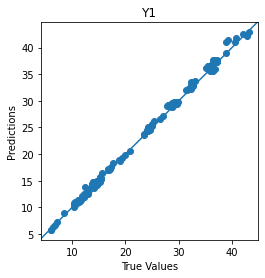

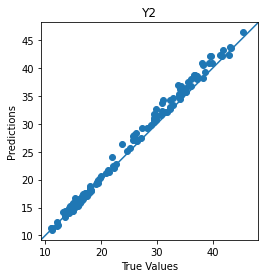

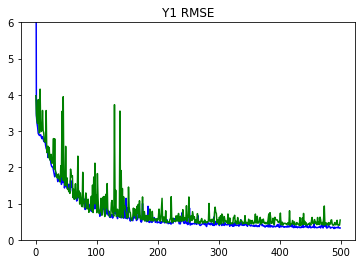

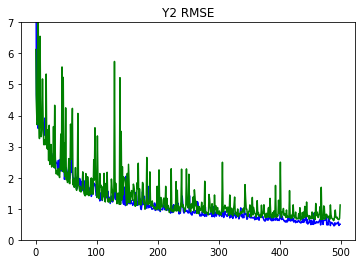

In [16]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)